In [1]:
import nest
import nest.raster_plot

import time
from numpy import exp

nest.ResetKernel()

# Assigning the current time to a variable in order to determine the build time of the network.
startbuild = time.time()

# Assigning the simulation parameters to variables.
dt = 0.1    # the resolution in ms
simtime = 1000.0  # Simulation time in ms
delay = 1.5    # synaptic delay in ms

# Definition of the parameters crucial for asynchronous irregular firing of the neurons.
g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

# Definition of the number of neurons in the network and the number of neuron recorded from
order = 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI   # number of neurons in total
N_rec = 50      # record from 50 neurons

# Definition of connectivity parameter
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)      # total number of synapses per neuron

# Initialization of the parameters of the integrate and fire neuron and the synapses. The parameter of the neuron are stored in a dictionary.
tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
J = 0.1   # postsynaptic amplitude in mV
nr_ports = 100  # number of receptor types
tau_syn = [0.1 + 0.01 * i for i in range(nr_ports)]
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta,
                 "tau_syn": tau_syn}
J_ex = J       # amplitude of excitatory postsynaptic current
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic current

# Definition of threshold rate, which is the external rate needed to fix the membrane potential
# around its threshold, the external firing rate and the rate of the poisson generator which is
# multiplied by the in-degree CE and converted to Hz by multiplication by 1000.
nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

# Configuration of the simulation kernel by the previously defined time resolution used in the simulation. Setting "print_time" to True prints the already processed simulation time as well as its percentage of the total simulation time.
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

print("Building network")

# Configuration of the model iaf_psc_exp_multisynapse and poisson_generator using SetDefaults(). This function expects the model to be the inserted as a string and the parameter to be specified in a dictionary. All instances of theses models created after this point will have the properties specified in the dictionary by default.
nest.SetDefaults("iaf_psc_exp_multisynapse", neuron_params)
nest.SetDefaults("poisson_generator", {"rate": p_rate})

# Creation of the nodes using Create. We store the returned handles in variables for later reference. Here the excitatory and inhibitory, as well as the poisson generator and two spike detectors. The spike detectors will later be used to record excitatory and inhibitory spikes.
nodes_ex = nest.Create("iaf_psc_exp_multisynapse", NE)
nodes_in = nest.Create("iaf_psc_exp_multisynapse", NI)
noise = nest.Create("poisson_generator")
espikes = nest.Create("spike_detector")
ispikes = nest.Create("spike_detector")

# Configuration of the spike detectors recording excitatory and inhibitory spikes using SetStatus, which expects a list of node handles and a list of parameter dictionaries. Setting the variable "to_file" to True ensures that the spikes will be recorded in a .gdf file starting with the string assigned to label. Setting "withtime" and "withgid" to True ensures that each spike is saved to file by stating the gid of the spiking neuron and the spike time in one line.
nest.SetStatus(espikes, [{"label": "brunel-py-ex",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(ispikes, [{"label": "brunel-py-in",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

print("Connecting devices")

# Definition of a synapse using CopyModel, which expects the model name of a pre-defined synapse, the name of the customary synapse and an optional parameter dictionary. The parameters defined in the dictionary will be the default parameter for the customary synapse. Here we define one synapse for the excitatory and one for the inhibitory connections giving the previously defined weights and equal delays.
nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

# Connecting the previously defined poisson generator to the excitatory and inhibitory neurons using the excitatory synapse. Since the poisson generator is connected to all neurons in the population the default rule ('all_to_all') of Connect() is used. The synaptic properties are pre-defined in a dictionary and inserted via syn_spec. As synaptic model the pre-defined synapses "excitatory" and "inhibitory" are choosen, thus setting weight and delay. The recepter type is drawn from a distribution for each connection, which is specified in the synapse properties by assigning a dictionary to the keyword 'receptor_type', which includes the specification of the distribution and the associated parameter.
syn_params_ex = {"model": "excitatory",
                 "receptor_type": {"distribution": "uniform_int",
                                   "low": 1, "high": nr_ports}
                 }
syn_params_in = {"model": "inhibitory",
                 "receptor_type": {"distribution": "uniform_int",
                                   "low": 1, "high": nr_ports}
                 }

nest.Connect(noise, nodes_ex, syn_spec=syn_params_ex)
nest.Connect(noise, nodes_in, syn_spec=syn_params_ex)

# Connecting the first N_rec nodes of the excitatory and inhibitory population to the associated spike detectors using excitatory synapses. Here the same shortcut for the specification of the synapse as defined above is used.
nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

# Connecting the excitatory population to all neurons while distribution the ports. Here we use the previously defined parameter dictionary syn_params_ex. Beforehand, the connection parameter are defined in a dictionary. Here we use the connection rule 'fixed_indegree', which requires the definition of the indegree.
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, syn_params_ex)

print("Inhibitory connections")

# Connecting the inhibitory population to all neurons while distribution the ports.
# Here we use the previously defined parameter dictionary syn_params_in.
# The connection parameter are defined analogously to the connection from the excitatory population
# defined above.
conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, syn_params_in)

# Storage of the time point after the buildup of the network in a variable.
endbuild = time.time()

# Simulation of the network.
print("Simulating")
nest.Simulate(simtime)

# Storage of the time point after the simulation of the network in a variable.
endsimulate = time.time()

# Reading out the total number of spikes received from the spike detector connected to the excitatory population and the inhibitory population.
events_ex = nest.GetStatus(espikes, "n_events")[0]
events_in = nest.GetStatus(ispikes, "n_events")[0]

# Calculation of the average firing rate of the excitatory and the inhibitory neurons by dividing the total number of recorded spikes by the number of neurons recorded from and the simulation time. The multiplication by 1000.0 converts the unit 1/ms to 1/s=Hz.
rate_ex = events_ex / simtime * 1000.0 / N_rec
rate_in = events_in / simtime * 1000.0 / N_rec

# Reading out the number of connections established using the excitatory and inhibitory synapse model. The numbers are summed up resulting in the total number of synapses.
num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

# Establishing the time it took to build and simulate the network by taking the difference of the pre-defined time variables.
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

# Printing the network properties, firing rates and building times.
print("Brunel network simulation (Python)")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("       Exitatory  : {0}".format(int(CE * N_neurons) + N_neurons))
print("       Inhibitory : {0}".format(int(CI * N_neurons)))
print("Excitatory rate   : %.2f Hz" % rate_ex)
print("Inhibitory rate   : %.2f Hz" % rate_in)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

# Plot a raster of the excitatory neurons and a histogram.
nest.raster_plot.from_device(espikes, hist=True)

Building network
Connecting devices
Connecting network
Excitatory connections
Inhibitory connections
Simulating
Brunel network simulation (Python)
Number of neurons : 12500
Number of synapses: 15637600
       Exitatory  : 12512500
       Inhibitory : 3125000
Excitatory rate   : 13.40 Hz
Inhibitory rate   : 22.56 Hz
Building time     : 5.94 s
Simulation time   : 187.80 s


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


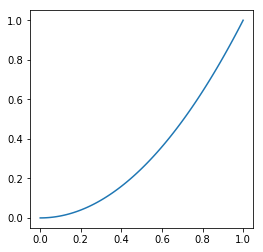

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.figure(figsize=[4, 4])
x = np.linspace(0, 1, 100)
y = x**2
plt.plot(x, y)
plt.savefig('wow.png')